In [1]:
import os
import shutil
from tqdm import tqdm
from collections import Counter

from _helpers import prepareData

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
from tensorflow import device as tf_device
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def get_dataframe_by_plate(plate):
    path = os.path.join(input_path, plate, 'extracted.csv')
    return prepareData(path)

In [5]:
root = '/home/stepan/Data/DFBS'
csv_name = 'Subtypes'
setting = '17_2'

input_path = f'{root}/Plates/{csv_name}/{setting}'
images_path = f'{root}/Plate_images/{csv_name}/{setting}'

In [6]:
plates = os.listdir(input_path)

In [7]:
data_list = list(map(get_dataframe_by_plate, plates))

In [8]:
data = pd.concat(data_list)

In [9]:
data['Sp type'].value_counts()

sdB        949
Mrk SB     757
C-H        728
C Ba       256
sdO        209
sdA        187
Mrk AGN    139
Mrk Abs    128
C-R         64
C-N         49
Name: Sp type, dtype: int64

In [10]:
# data = data[data['Sp type'].isin({'sdB', 'C-H', 'Mrk SB', 'C Ba'})]

In [11]:
train_indices, test_indices = train_test_split(data.index.unique(), test_size=0.15, shuffle=True)

In [12]:
train_indices

Int64Index([1057, 1387, 1634, 2491, 1175,  394, 2340,   94, 1718, 2858,
            ...
            1662, 1469,  703, 1087, 1299, 2919, 1872, 1823, 1284, 2990],
           dtype='int64', name='Unnamed: 0', length=1771)

In [11]:
df_train, df_test = data.loc[train_indices][['Sp type', 'path']], data.loc[test_indices][['Sp type', 'path']]

In [12]:
df_train['fname'] = df_train['path'].str.split('/', expand=True, ).iloc[:,-1]
df_train.rename(columns={"Sp type": "Cl"}, inplace=True)
df_test['fname'] = df_test['path'].str.split('/', expand=True, ).iloc[:,-1]
df_test.rename(columns={"Sp type": "Cl"}, inplace=True)

In [13]:
df_train.head()

,Cl,path,fname
Unnamed: 0,,,
1014,Mrk Abs,data/Plates/Subtypes/17_2/fbs1258M_cor/images/...,1014__658.tiff
511,C-H,data/Plates/Subtypes/17_2/fbs1012_cor/images/5...,511__J163400.29+544829.5.tiff
273,C-H,data/Plates/Subtypes/17_2/fbs0368_cor/images/2...,273__J171729.25+171357.3.tiff
273,C-H,data/Plates/Subtypes/17_2/fbs1567_cor/images/2...,273__J171729.25+171357.3.tiff
273,C-H,data/Plates/Subtypes/17_2/fbs1687_cor/images/2...,273__J171729.25+171357.3.tiff


In [14]:
def make_directory(path):
    folders = path.split('/')
    current_path = ''
    for folder in folders[:-1]:
        current_path += folder + '/' 
        try:
            os.mkdir(current_path)
        except OSError as error:
            pass
    current_path += folders[-1]
    shutil.rmtree(current_path, ignore_errors=True)
    os.mkdir(current_path)

def augment(data, n_times=1, batch_size=2, img_size=(140,20), input_path='data/images/',
            output_path='data/augmented/', seed = None, save_format='png', x_col='fname', y_col="Cl",
            shuffle=False, color_mode='grayscale', class_mode="categorical"):
    n_steps_data_aug = np.ceil(data.shape[0]/batch_size).astype(int)
    save_prefix = 'aug'
    
    datagen = ImageDataGenerator(
        rotation_range=1,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="nearest"
        # rescale = 1./0xff
    )
    
    aug_gen = datagen.flow_from_dataframe(dataframe=data, directory=input_path,
                                          save_to_dir=output_path, save_prefix=save_prefix,
                                          save_format=save_format, x_col=x_col, y_col=y_col,
                                          batch_size=batch_size, seed=seed,
                                          shuffle=shuffle, color_mode=color_mode,
                                          class_mode=class_mode, target_size=img_size)

    make_directory(output_path)

    for i in tqdm(range(n_times*n_steps_data_aug)):
        next(aug_gen)

    augmented_images = np.array(os.listdir(output_path))
    aug_data = pd.concat([pd.Series(augmented_images).str.split('_', expand=True)[1], output_path + pd.Series(augmented_images)], axis=1)

    aug_data[y_col] = data[y_col].iloc[aug_data[1]].values
    aug_data[1] = data.iloc[aug_data[1]].index
    aug_data.rename(columns={0: "path", 1: "data_index"}, inplace=True)

    return aug_data, aug_gen.classes

In [15]:
img_size = (140, 20)
train_out_path = os.path.join(images_path, 'augmented/train/')
test_out_path = os.path.join(images_path, 'augmented/test/') 

In [16]:
aug_train, aug_classes = augment(df_train, n_times=8, batch_size=4, img_size=img_size,
                                 input_path=None, output_path=train_out_path,
                                 seed=None, save_format='tiff', x_col='path')
aug_test, _ = augment(df_test, n_times=2, batch_size=4, img_size=img_size, input_path=None,
                      output_path=test_out_path, seed=None, save_format='tiff', x_col='path')
aug_train.head()

Found 2910 validated image filenames belonging to 10 classes.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5824/5824 [00:14<00:00, 409.03it/s]


Found 545 validated image filenames belonging to 10 classes.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 395.37it/s]


,data_index,path,Cl
0,210,data/Plate_images/Subtypes/17_2/augmented/trai...,C Ba
1,676,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H
2,552,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H
3,1551,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB
4,1310,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB


In [17]:
df_train

,Cl,path,fname
Unnamed: 0,,,
1014,Mrk Abs,data/Plates/Subtypes/17_2/fbs1258M_cor/images/...,1014__658.tiff
511,C-H,data/Plates/Subtypes/17_2/fbs1012_cor/images/5...,511__J163400.29+544829.5.tiff
273,C-H,data/Plates/Subtypes/17_2/fbs0368_cor/images/2...,273__J171729.25+171357.3.tiff
273,C-H,data/Plates/Subtypes/17_2/fbs1567_cor/images/2...,273__J171729.25+171357.3.tiff
273,C-H,data/Plates/Subtypes/17_2/fbs1687_cor/images/2...,273__J171729.25+171357.3.tiff
...,...,...,...
1790,sdA,data/Plates/Subtypes/17_2/fbs0034_cor/images/1...,1790__PG0110+262.tiff
1690,Mrk SB,data/Plates/Subtypes/17_2/fbs1224M_cor/images/...,1690__597.tiff
1519,Mrk SB,data/Plates/Subtypes/17_2/fbs1104_cor/images/1...,1519__1375.tiff


In [18]:
df_train = aug_train
df_test = aug_test

In [19]:
df_train.head()

,data_index,path,Cl
0,210,data/Plate_images/Subtypes/17_2/augmented/trai...,C Ba
1,676,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H
2,552,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H
3,1551,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB
4,1310,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB


In [20]:
train_raw = df_train[['path', 'Cl']]
test_raw = df_test[['path', 'Cl']]

In [21]:
train_raw['data_index'] = train_raw.index
test_raw['data_index'] = test_raw.index

In [22]:
train_raw.head()

,path,Cl,data_index
0,data/Plate_images/Subtypes/17_2/augmented/trai...,C Ba,0
1,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H,1
2,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H,2
3,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB,3
4,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB,4


In [23]:
aug_train.head()

,data_index,path,Cl
0,210,data/Plate_images/Subtypes/17_2/augmented/trai...,C Ba
1,676,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H
2,552,data/Plate_images/Subtypes/17_2/augmented/trai...,C-H
3,1551,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB
4,1310,data/Plate_images/Subtypes/17_2/augmented/trai...,Mrk SB


In [24]:
df_train = pd.concat([train_raw, aug_train]).reset_index()
df_test = pd.concat([test_raw, aug_test]).reset_index()

In [25]:
df_train['Cl'].value_counts()

sdB        12672
Mrk SB     10368
C-H         9616
C Ba        3488
sdA         2704
sdO         2672
Mrk AGN     1920
Mrk Abs     1712
C-R          816
C-N          592
Name: Cl, dtype: int64

In [26]:
df_test['Cl'].value_counts()

sdB        600
C-H        516
Mrk SB     420
C Ba       148
sdO        116
sdA        108
Mrk Abs    104
Mrk AGN     80
C-N         44
C-R         44
Name: Cl, dtype: int64

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train['Cl'])
df_train['Cl']=le.transform(df_train['Cl'])
df_test['Cl']=le.transform(df_test['Cl'])

In [28]:
df_train['Cl'].value_counts()

8    12672
6    10368
1     9616
0     3488
7     2704
9     2672
4     1920
5     1712
3      816
2      592
Name: Cl, dtype: int64

In [29]:
df_test['Cl'].value_counts()

8    600
1    516
6    420
0    148
9    116
7    108
5    104
4     80
2     44
3     44
Name: Cl, dtype: int64

In [30]:
X_tr = df_train['path']
Y_tr = df_train['Cl']
X_tr = X_tr.values
Y_tr = Y_tr.values

X_ts = df_test['path']
Y_ts = df_test['Cl']
X_ts = X_ts.values
Y_ts = Y_ts.values

In [92]:
images_list_train = []
max_width = 0
max_height = 0
ind = 0

for i in range(len(X_tr)):
    im = Image.open(X_tr[i])
    arr = np.array(im)

    arr=(arr-arr.min())/(arr.max()-arr.min())

    if arr.mean() > 0.5:
        arr = 1 - arr

    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list_train.append(arr)
    
images_list_test = []
ind = 0
for i in range(len(X_ts)):
    im = Image.open(X_ts[i])
    arr = np.array(im)
    
    arr=(arr-arr.min())/(arr.max()-arr.min())

    if arr.mean() > 0.5:
        arr = 1 - arr
    
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list_test.append(arr)

In [93]:
max_height, max_width

(140, 20)

In [94]:
max_width = 50
max_height = 160

In [95]:
print(max_width, max_height)

50 160


In [ ]:
for i in range(len(images_list_train)):
    s = images_list_train[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list_train[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list_train[i] = arr.flatten()

for i in range(len(images_list_test)):
    s = images_list_test[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list_test[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list_test[i] = arr.flatten()

In [37]:
images_np_train = np.array(images_list_train)
images_np_test = np.array(images_list_test)

In [38]:
class_count = len(df_train['Cl'].unique())
X_train = images_np_train
Y_train = Y_tr
Y_train = to_categorical(Y_train, class_count)

X_test = images_np_test
Y_test = Y_ts
Y_test = to_categorical(Y_test, class_count)

In [39]:
X_train = X_train.reshape(X_train.shape[0], max_height, max_width, 1)
X_test = X_test.reshape(X_test.shape[0], max_height, max_width, 1)
input_shape = (max_height, max_width, 1)

In [40]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (22830, 160, 50, 1)
22830 train samples
1588 test samples


In [43]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), input_shape=input_shape, padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count,activation='softmax'))

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 160, 50, 128)      1280      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 80, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 25, 128)       147584    
                                                                 
 activation_4 (Activation)   (None, 80, 25, 128)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 12, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 12, 64)       

In [45]:
adadelta = optimizers.Adadelta(learning_rate=0.01, rho=0.95)
model.compile(optimizer=adadelta , loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
checkpoint_directory = f'data/Checkpoints/Plates/{csv_name}/{setting}/'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_directory + 'checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

make_directory(checkpoint_directory)

def lr_schedule(epoch):
    lrate = 0.002
    if epoch > 3:
        lrate = 0.001
    if epoch > 6:
        lrate = 0.0005
    if epoch > 9:
        lrate = 0.00025
    if epoch > 12:
        lrate = 0.0001
    if epoch > 15:
        lrate = 0.00005
    return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)

In [38]:
counter = Counter(aug_classes)
max_val = float(max(counter.values()))       
cw = {class_id : max_val/num_images for class_id, num_images in counter.items()}

with tf_device('GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 35, batch_size = 8, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw, callbacks=[model_checkpoint_callback])
#     Learning rate scheduler
#     history = model.fit(X_train, Y_train, epochs = 20, batch_size = 8, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw, callbacks=[model_checkpoint_callback, lr_scheduler])

2022-09-26 23:01:10.985886: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 363040000 exceeds 10% of free system memory.
2022-09-26 23:01:11.218406: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 363040000 exceeds 10% of free system memory.


Epoch 1/35


2022-09-26 23:01:12.436470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-09-26 23:01:13.497150: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-26 23:01:13.497456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-26 23:01:13.497475: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-26 23:01:13.497895: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-26 23:01:13.497954: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-26 23:01:14.442359: W tensorflow/core/common_runtime/bf

   6/1419 [..............................] - ETA: 15s - loss: 2.1218 - accuracy: 0.2917    

2022-09-26 23:01:15.206741: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-26 23:01:15.206786: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-26 23:01:15.236807: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-26 23:01:15.236848: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

1416/1419 [============================>.] - ETA: 0s - loss: 1.6339 - accuracy: 0.5195

2022-09-26 23:01:30.051354: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-26 23:01:30.051394: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1419/1419 [==============================] - ETA: 0s - loss: 1.6333 - accuracy: 0.5197

2022-09-26 23:01:30.343796: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-26 23:01:30.343839: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-26 23:01:30.431376: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26304000 exceeds 10% of free system memory.


1419/1419 [==============================] - 20s 11ms/step - loss: 1.6333 - accuracy: 0.5197 - val_loss: 0.8385 - val_accuracy: 0.6253
Epoch 2/35
1419/1419 [==============================] - 15s 11ms/step - loss: 1.3020 - accuracy: 0.6375 - val_loss: 0.7321 - val_accuracy: 0.6959
Epoch 3/35
1419/1419 [==============================] - 15s 11ms/step - loss: 1.2152 - accuracy: 0.6637 - val_loss: 0.7257 - val_accuracy: 0.6813
Epoch 4/35
1419/1419 [==============================] - 16s 11ms/step - loss: 1.1458 - accuracy: 0.6885 - val_loss: 0.6700 - val_accuracy: 0.7007
Epoch 5/35
1419/1419 [==============================] - 16s 11ms/step - loss: 1.0986 - accuracy: 0.7054 - val_loss: 0.6777 - val_accuracy: 0.7032
Epoch 6/35
1419/1419 [==============================] - 16s 11ms/step - loss: 1.0644 - accuracy: 0.7098 - val_loss: 0.6375 - val_accuracy: 0.7165
Epoch 7/35
1419/1419 [==============================] - 16s 11ms/step - loss: 1.0434 - accuracy: 0.7143 - val_loss: 0.6227 - val_accura

In [52]:
model.compile(optimizer='adamax' , loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
with tf_device('GPU:0'):
    history_1 = model.fit(X_train, Y_train, epochs = 15, batch_size = 8, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw, callbacks=[model_checkpoint_callback])


Epoch 1/15
1274/1274 [==============================] - 14s 10ms/step - loss: 0.5149 - accuracy: 0.8473 - val_loss: 0.3981 - val_accuracy: 0.8656
Epoch 2/15
1274/1274 [==============================] - 13s 10ms/step - loss: 0.3612 - accuracy: 0.8854 - val_loss: 0.4881 - val_accuracy: 0.8514
Epoch 3/15
1274/1274 [==============================] - 13s 10ms/step - loss: 0.3028 - accuracy: 0.9068 - val_loss: 0.4046 - val_accuracy: 0.8514
Epoch 4/15
1274/1274 [==============================] - 13s 11ms/step - loss: 0.2540 - accuracy: 0.9224 - val_loss: 0.3901 - val_accuracy: 0.8695
Epoch 5/15
1274/1274 [==============================] - 13s 11ms/step - loss: 0.2164 - accuracy: 0.9354 - val_loss: 0.3367 - val_accuracy: 0.8786
Epoch 6/15
1274/1274 [==============================] - 14s 11ms/step - loss: 0.1728 - accuracy: 0.9487 - val_loss: 0.3317 - val_accuracy: 0.8966
Epoch 7/15
1274/1274 [==============================] - 14s 11ms/step - loss: 0.1464 - accuracy: 0.9570 - val_loss: 0.3781 -

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Dropout, Flatten, LeakyReLU
model1 = Sequential()

model1.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu', input_shape = input_shape))
model1.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization())
model.add(Dropout(0.2))

model1.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization())
model.add(Dropout(0.2))

model1.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(MaxPool2D(2))
model.add(BatchNormalization())

model1.add(Flatten())
model1.add(Dropout(0.3))

model1.add(Dense(256, kernel_initializer = 'glorot_normal', activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation = 'softmax'))

In [48]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 160, 50, 32)       320       
                                                                 
 conv2d_11 (Conv2D)          (None, 160, 50, 32)       9248      
                                                                 
 conv2d_12 (Conv2D)          (None, 160, 50, 32)       9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 80, 25, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 80, 25, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 25, 64)       

In [49]:
model1.compile(optimizer = adadelta, loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    min_delta = 1e-5,
    mode = 'max',
    restore_best_weights = True,
    verbose = 1
)

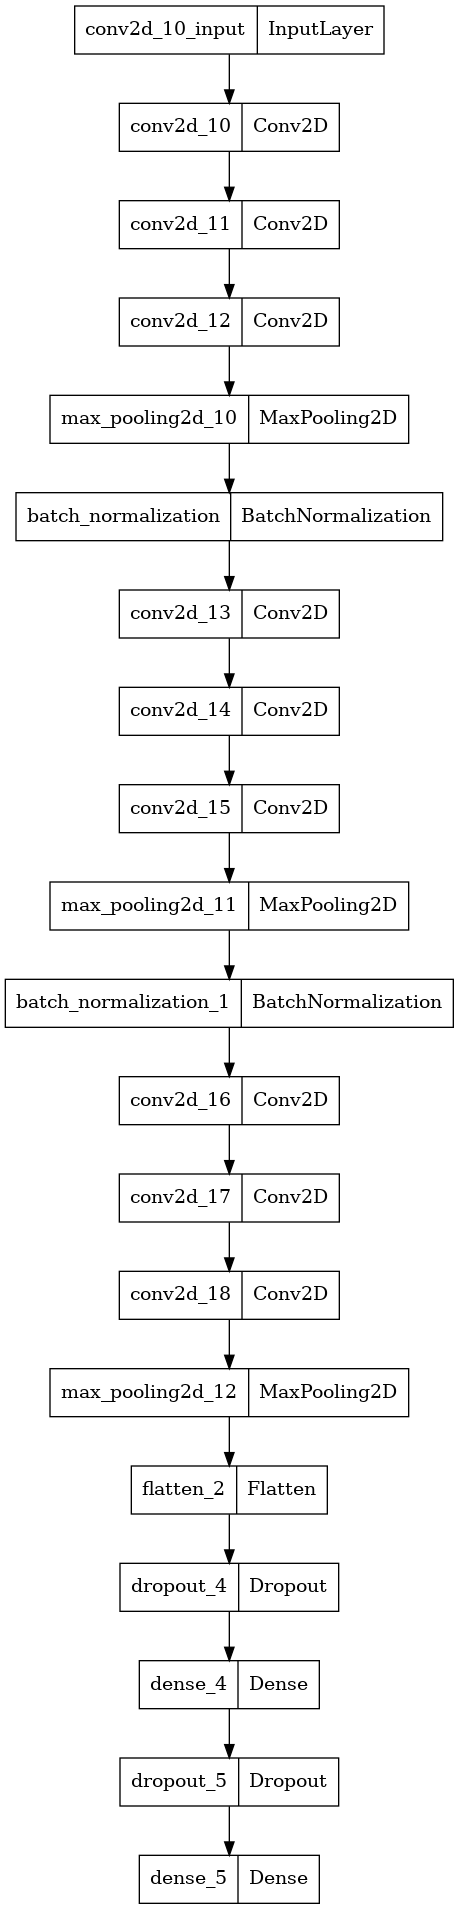

In [53]:
plot_model(
    model1,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [157]:
from tensorflow.keras import backend as keras_backend
keras_backend.set_value(model1.optimizer.learning_rate, 1e-3)
with tf_device('GPU:0'):
    history = model1.fit(X_train, Y_train, epochs=30, validation_data=(X_test, Y_test), verbose = 1, callbacks = [earlyStop])
# Charts(history)

Epoch 1/30
427/427 [==============================] - 22s 50ms/step - loss: 1.2848 - accuracy: 0.4068 - val_loss: 1.3518 - val_accuracy: 0.3193
Epoch 2/30
427/427 [==============================] - 20s 47ms/step - loss: 1.0741 - accuracy: 0.5606 - val_loss: 0.9157 - val_accuracy: 0.6889
Epoch 3/30
427/427 [==============================] - 20s 47ms/step - loss: 0.9573 - accuracy: 0.6265 - val_loss: 0.8112 - val_accuracy: 0.7054
Epoch 4/30
427/427 [==============================] - 20s 48ms/step - loss: 0.8840 - accuracy: 0.6560 - val_loss: 0.7644 - val_accuracy: 0.7129
Epoch 5/30
427/427 [==============================] - 21s 48ms/step - loss: 0.8460 - accuracy: 0.6657 - val_loss: 0.7339 - val_accuracy: 0.7228
Epoch 6/30
427/427 [==============================] - 21s 49ms/step - loss: 0.8117 - accuracy: 0.6794 - val_loss: 0.7151 - val_accuracy: 0.7244
Epoch 7/30
427/427 [==============================] - 21s 49ms/step - loss: 0.7870 - accuracy: 0.6876 - val_loss: 0.6980 - val_accuracy:

In [46]:
history

In [108]:
with tf_device('GPU:0'):
    history_1 = model1.fit(X_train, Y_train, epochs=30, validation_data=(X_test, Y_test), verbose = 1, callbacks = [earlyStop])

Epoch 1/30
354/354 [==============================] - 16s 46ms/step - loss: 0.6019 - accuracy: 0.7687 - val_loss: 0.6013 - val_accuracy: 0.7452
Epoch 2/30
354/354 [==============================] - 17s 47ms/step - loss: 0.5911 - accuracy: 0.7725 - val_loss: 0.5963 - val_accuracy: 0.7488
Epoch 3/30
354/354 [==============================] - 17s 47ms/step - loss: 0.5887 - accuracy: 0.7745 - val_loss: 0.5961 - val_accuracy: 0.7464
Epoch 4/30
354/354 [==============================] - 17s 48ms/step - loss: 0.5911 - accuracy: 0.7766 - val_loss: 0.5934 - val_accuracy: 0.7488
Epoch 5/30
354/354 [==============================] - 17s 48ms/step - loss: 0.5838 - accuracy: 0.7767 - val_loss: 0.5909 - val_accuracy: 0.7524
Epoch 6/30
354/354 [==============================] - 17s 48ms/step - loss: 0.5823 - accuracy: 0.7823 - val_loss: 0.5907 - val_accuracy: 0.7512
Epoch 7/30
354/354 [==============================] - 17s 49ms/step - loss: 0.5816 - accuracy: 0.7771 - val_loss: 0.5888 - val_accuracy:

In [109]:
with tf_device('GPU:0'):
    history_2 = model1.fit(X_train, Y_train, epochs=30, validation_data=(X_test, Y_test), verbose = 1, callbacks = [earlyStop])

Epoch 1/30
354/354 [==============================] - 16s 46ms/step - loss: 0.5233 - accuracy: 0.8007 - val_loss: 0.5594 - val_accuracy: 0.7656
Epoch 2/30
354/354 [==============================] - 16s 46ms/step - loss: 0.5205 - accuracy: 0.8022 - val_loss: 0.5582 - val_accuracy: 0.7656
Epoch 3/30
354/354 [==============================] - 17s 47ms/step - loss: 0.5191 - accuracy: 0.8005 - val_loss: 0.5576 - val_accuracy: 0.7667
Epoch 4/30
354/354 [==============================] - 17s 47ms/step - loss: 0.5205 - accuracy: 0.8006 - val_loss: 0.5548 - val_accuracy: 0.7667
Epoch 5/30
354/354 [==============================] - 17s 48ms/step - loss: 0.5135 - accuracy: 0.8037 - val_loss: 0.5549 - val_accuracy: 0.7632
Epoch 6/30
354/354 [==============================] - 17s 48ms/step - loss: 0.5150 - accuracy: 0.8038 - val_loss: 0.5576 - val_accuracy: 0.7632
Epoch 7/30
354/354 [==============================] - 17s 48ms/step - loss: 0.5156 - accuracy: 0.8039 - val_loss: 0.5535 - val_accuracy:

In [49]:
adadelta1 = optimizers.Adadelta(learning_rate=0.05, rho=0.95)
model1.compile(optimizer=adadelta1 , loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
with tf_device('GPU:0'):
    history_2 = model1.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test), verbose = 1, callbacks = [earlyStop])

Epoch 1/5
355/355 [==============================] - 17s 47ms/step - loss: 0.5603 - accuracy: 0.7792 - val_loss: 0.5345 - val_accuracy: 0.7871
Epoch 2/5
355/355 [==============================] - 17s 48ms/step - loss: 0.5083 - accuracy: 0.7995 - val_loss: 0.5195 - val_accuracy: 0.8090
Epoch 3/5
355/355 [==============================] - 17s 48ms/step - loss: 0.4729 - accuracy: 0.8117 - val_loss: 0.5068 - val_accuracy: 0.7993
Epoch 4/5
355/355 [==============================] - 17s 49ms/step - loss: 0.4427 - accuracy: 0.8230 - val_loss: 0.5458 - val_accuracy: 0.8066
Epoch 5/5
355/355 [==============================] - 17s 49ms/step - loss: 0.4137 - accuracy: 0.8324 - val_loss: 0.5020 - val_accuracy: 0.8151


In [51]:
with tf_device('GPU:0'):
    history_3 = model1.fit(X_train, Y_train, epochs=15, validation_data=(X_test, Y_test), verbose = 1, callbacks = [earlyStop])

Epoch 1/15
355/355 [==============================] - 16s 46ms/step - loss: 0.3900 - accuracy: 0.8415 - val_loss: 0.4980 - val_accuracy: 0.8102
Epoch 2/15
355/355 [==============================] - 16s 46ms/step - loss: 0.3670 - accuracy: 0.8499 - val_loss: 0.5024 - val_accuracy: 0.8200
Epoch 3/15
355/355 [==============================] - 17s 47ms/step - loss: 0.3411 - accuracy: 0.8610 - val_loss: 0.5084 - val_accuracy: 0.8005
Epoch 4/15
355/355 [==============================] - 17s 47ms/step - loss: 0.3188 - accuracy: 0.8687 - val_loss: 0.5018 - val_accuracy: 0.8114
Epoch 5/15
355/355 [==============================] - 17s 47ms/step - loss: 0.3033 - accuracy: 0.8755 - val_loss: 0.5891 - val_accuracy: 0.8236
Epoch 6/15
355/355 [==============================] - 17s 48ms/step - loss: 0.2858 - accuracy: 0.8840 - val_loss: 0.5386 - val_accuracy: 0.8054
Epoch 7/15
355/355 [==============================] - 17s 48ms/step - loss: 0.2670 - accuracy: 0.8895 - val_loss: 0.4980 - val_accuracy: